In [328]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import scipy.sparse.linalg
import torch
import re
from torch.nn.functional import conv2d
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [300]:
from crf.crf import *
from crf.utils import read_image, read_pfm, read_pgm
#from sklearn.feature_extraction.image import extract_patches_2d


In [329]:
img1 = read_image('imL.png')#[::2,::2]
img2 = read_image('imR.png')#[::2,::2]
#img1 = read_image('im0.png')[::3,::3]
#img2 = read_image('im1.png')[::3,::3]
#gt_depth = read_pfm('disp0.pfm')[::3,::3]
gt_depth = read_pgm('truedisp.row3.col3.pgm')

In [299]:
conv = sp.ndimage.filters.convolve

# def normalized(img,window_size=9):
#     box = np.ones((window_size,window_size,1))/window_size**2
#     mean = conv(img,box)
#     diff = img-mean
#     std = np.sqrt(conv(diff**2, box))
#     normalized_img = diff/std
#     return normalized_img

def SD(imga,imgb):
    return (imga-imgb)**2
def AD(imga,imgb):
    return np.abs(imga-imgb)
def nprod(imga,imgb):
    return -1*imga*imgb

In [275]:
max_disp=30
ws = 11

nimg1 = normalized(img1,ws)
nimg2 = normalized(img2,ws)

h,w,c = nimg1.shape
padded_im1 = np.pad(nimg1,((0,0),(max_disp,0),(0,0)), mode='constant')
padded_im2 = np.pad(nimg2,((0,0),(max_disp,0),(0,0)), mode='constant')

out = np.zeros((h,w,max_disp))
for i in np.arange(max_disp):#1+np.arange(-w//2,w//2):
    shifted_nimg2 = padded_im2[:,max_disp-i:w+max_disp-i]
    out[:,:,i] = AD(nimg1,shifted_nimg2).sum(2)

Text(0.5,1,'Unary (max with AD)')

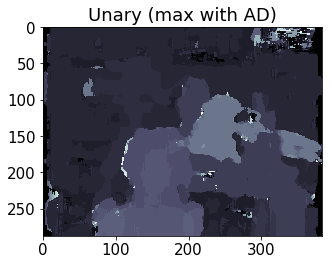

In [386]:
box = np.ones((ws,ws,1))
aggregated = sp.ndimage.filters.convolve(out,box)
disps = np.argmin(aggregated,axis=-1)#*(1+.5*np.arange(max_disp)/max_disp),axis=-1)
plt.rcParams.update({'font.size': 15, 'figure.figsize':(5,5)})
f = plt.figure(figsize=(5,5))
plt.imshow(disps,cmap='bone')
plt.title("Unary (max with AD)")
#plt.colorbar()

Text(0.5,1,'Tsukuba')

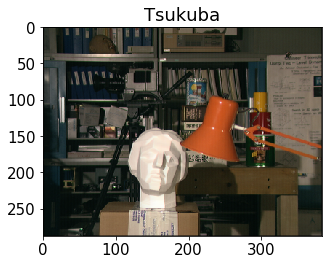

In [388]:
plt.imshow(img1)
plt.title("Tsukuba")
#plt.colorbar()

In [278]:
def gaussian_kernel(k=3,sigma=.3):
    x,y = np.mgrid[-k//2:k//2,-k//2:k//2]+1
    kernel = np.exp(-(x**2 +y**2)/(2*sigma**2))
    return kernel/kernel.sum()

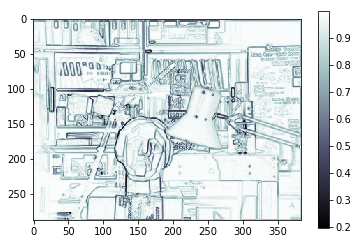

In [279]:
def squash(img):
    a = (0,1)
    return (img - np.amin(img,axis=a))/(np.amax(img,axis=a)-np.amin(img,axis=a))


lap_2d = np.array([[ 0,-1, 0],[-1, 4,-1],[ 0,-1, 0]])
Dx = np.array([[-1/2,0,1/2]])
Dy = Dx.T
bimg2 = img1#bimg2 = conv(img2,gaussian_kernel(sigma=1)[...,None])
edgex = np.linalg.norm(conv(bimg2,Dx[...,None]),axis=-1)
edgey = np.linalg.norm(conv(bimg2,Dy[...,None]),axis=-1)
remap = lambda img: np.exp(-2*conv(img,gaussian_kernel(k=3,sigma=.3)))

bedgex = remap(edgex)
bedgey = remap(edgey)
edges = np.sqrt(edgex**2+edgey**2)
#bedges = conv(edges,gaussian_kernel(k=9,sigma=15))
bedges = remap(edges)
plt.imshow(bedges,cmap='bone')
plt.colorbar()

In [319]:
import cv2
from cv2.ximgproc import guidedFilter,amFilter,jointBilateralFilter
from PIL import Image

In [320]:
help(jointBilateralFilter)

Help on built-in function jointBilateralFilter:

jointBilateralFilter(...)
    jointBilateralFilter(joint, src, d, sigmaColor, sigmaSpace[, dst[, borderType]]) -> dst
    .   @brief Applies the joint bilateral filter to an image.
    .   
    .   @param joint Joint 8-bit or floating-point, 1-channel or 3-channel image.
    .   
    .   @param src Source 8-bit or floating-point, 1-channel or 3-channel image with the same depth as joint
    .   image.
    .   
    .   @param dst Destination image of the same size and type as src .
    .   
    .   @param d Diameter of each pixel neighborhood that is used during filtering. If it is non-positive,
    .   it is computed from sigmaSpace .
    .   
    .   @param sigmaColor Filter sigma in the color space. A larger value of the parameter means that
    .   farther colors within the pixel neighborhood (see sigmaSpace ) will be mixed together, resulting in
    .   larger areas of semi-equal color.
    .   
    .   @param sigmaSpace Filter sigma

In [281]:
cimg2 = Image.fromarray(np.uint8(img2*255))
cdisps = Image.fromarray(np.uint8(disps*255))
gray = lambda rgb: np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

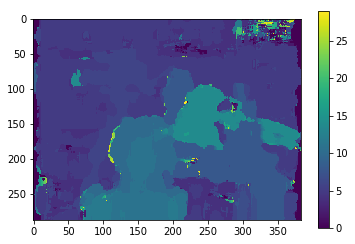

In [282]:
plt.imshow(np.uint8(disps))
plt.colorbar()

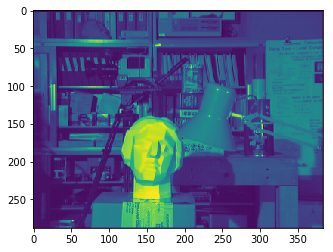

In [283]:
plt.imshow(np.uint8(gray(img1)*255))

Text(0.5,1,'Ground Truth')

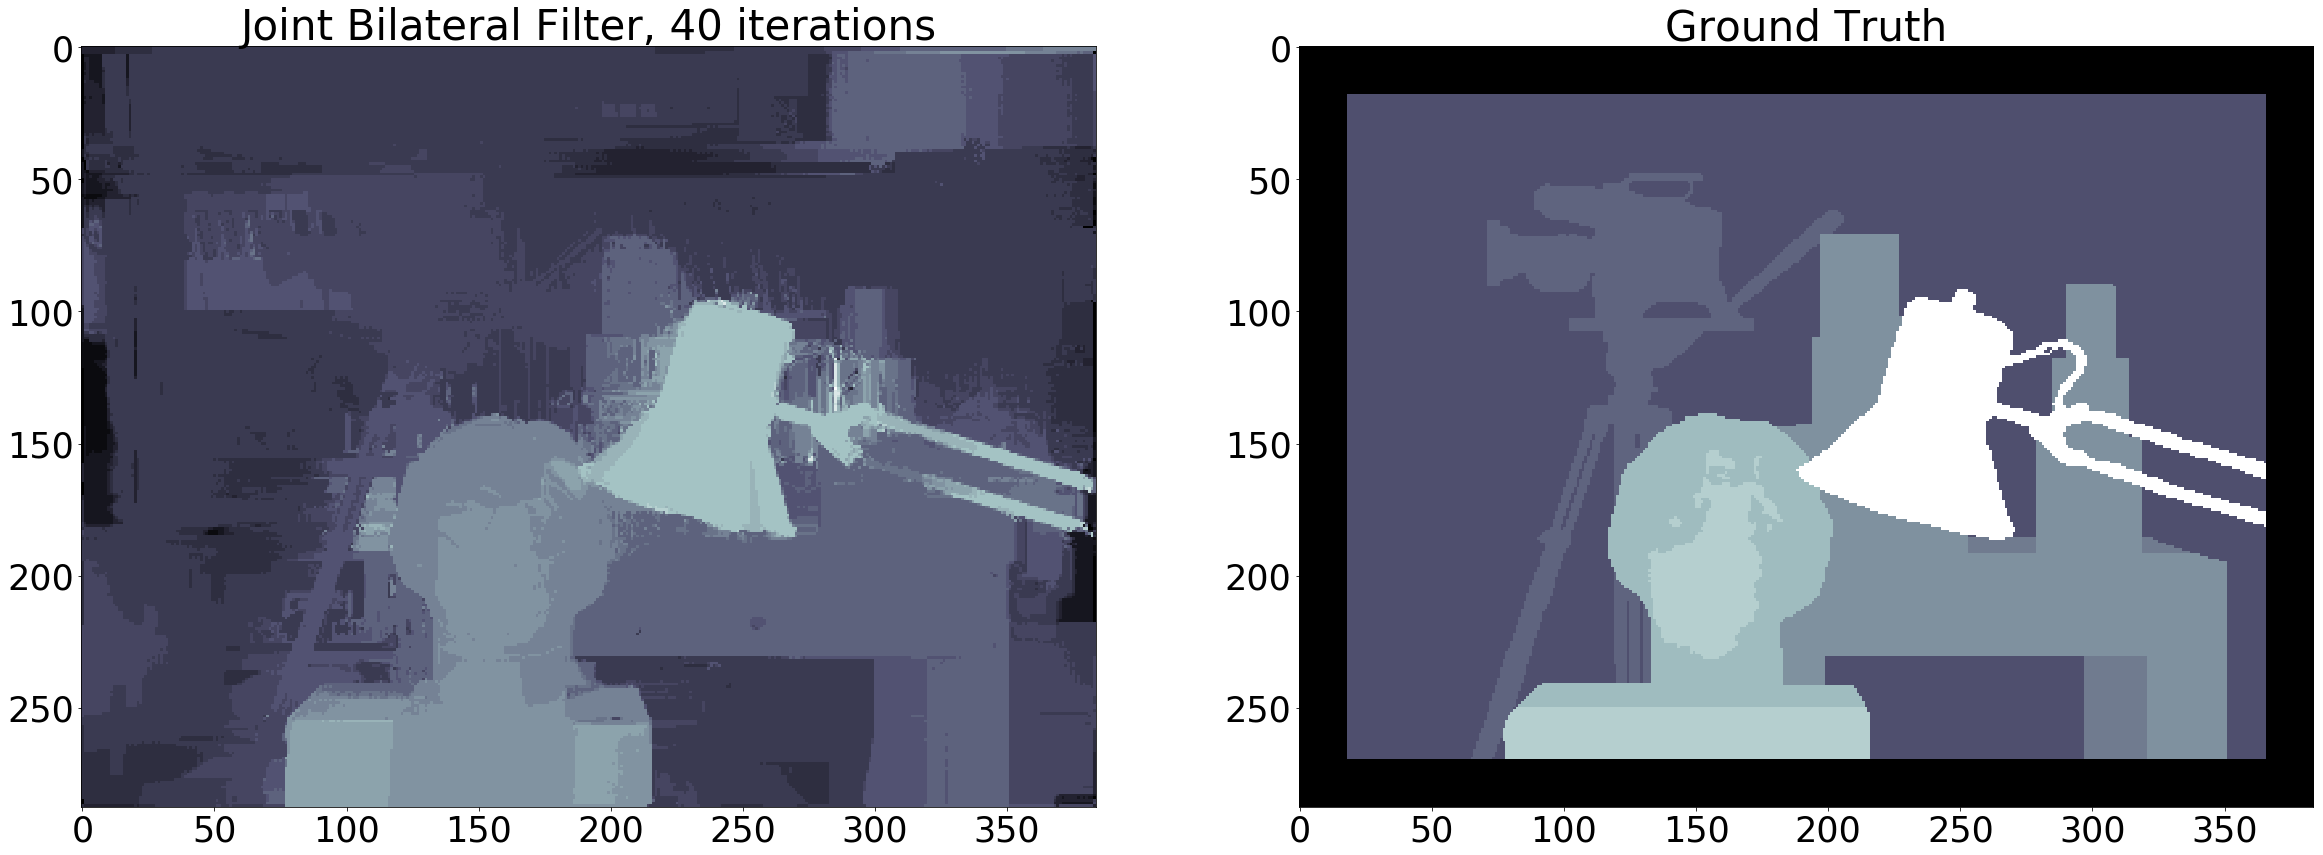

In [423]:
n = img1#normalized(img1,window_shape=(30,30))
guide_img = np.uint8(255*(n - n.min())/(n.max()-n.min()))
radius = 20
eps = .1**.5

n = guide_img.shape[0]*guide_img.shape[1]
def mvm(v):
    img = np.uint8(v.reshape(guide_img.shape[:2])*255)
    out_img = jointBilateralFilter(guide_img,img,d=-1,sigmaColor=5,sigmaSpace=10)
    #out_img = jointBilateralFilter(guide_img,img,d=-1,sigmaColor=10,sigmaSpace=5)
    #out_img = guidedFilter(guide_img,img,radius,eps)
    #out_img = amFilter(guide_img,img,sigma_s=50,sigma_r=.03)
    return out_img.reshape(-1)/255.

x = disps.reshape(-1)/255.
I = identity_op(disps.shape)
F = sp.sparse.linalg.LinearOperator((n,n), mvm)

n_iter =40
for i in range(n_iter):
    x = F(x)

# alpha = 4
# map_disp = sp.sparse.linalg.cg((1+alpha)*I - alpha*F,x,maxiter=n_iter)[0]#.reshape((h,w))
# x = map_disp



plt.rcParams.update({'font.size': 35})
f, axarr = plt.subplots(1,2,figsize=(40,20))
a0 = axarr[0].imshow(255*x.reshape((h,w)),cmap='bone')

a1 = axarr[1].imshow(gt_depth,cmap='bone')
axarr[0].set_title("Joint Bilateral Filter, {} iterations".format(n_iter))
axarr[1].set_title("Ground Truth")
#print(max_disp)
#plt.imshow(max_disp,cmap='bone')
#f.colorbar(a0)

In [266]:
(I+.01*A)(x).shape

(110592,)

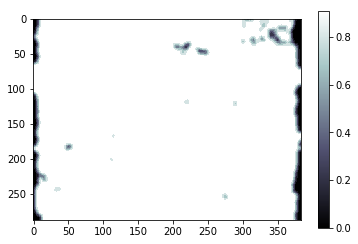

In [130]:
#filtered = guidedFilter(np.uint8(gray(img2)),np.uint8(disps),radius=3,eps=3)
G2 = guided_op(np.uint8(gray(img2)),radius,eps)
x = np.uint8(disps.reshape(-1))
for i in range(1):
    x = G2(x)
filtered = x.reshape((h,w))
plt.imshow(filtered,cmap='bone')
plt.colorbar()

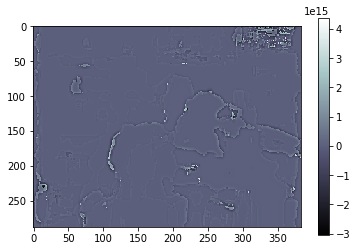

In [113]:
alpha=3
I = identity_op(disps.shape)

y_var = I
A = G2#.5*(I+alpha*G2)
map_disp = sp.sparse.linalg.cg(A,y_var(disps.reshape(-1)),maxiter=100)[0].reshape((h,w))
plt.imshow(map_disp,cmap='bone')
plt.colorbar()

In [ ]:
plt.imshow(map_disp,cmap='bone')
plt.colorbar()
plt.show()
plt.imshow(disps,cmap='bone')
plt.colorbar()
plt.show()

In [ ]:
alpha=3
D2 = laplacian_op(disps.shape)
I = identity_op(disps.shape)
d2x = np.array([[-1,2,-1]])
d2y = d2x.T
D2x = convolve_op(d2x,disps.shape)
D2y = convolve_op(d2y,disps.shape)
#G = convolve_op(gaussian_kernel(sigma=.3),disps.shape)
# dx = np.array([[-1/2,0,1/2]])
# Dx = convolve_op(dx,disps.shape)
# Dy = convolve_op(dx.T,disps.shape)
Qx = I#diag_op(bedgex)
Qy = I#diag_op(bedgey)
Q = diag_op(bedges)
y_var = I
A = (y_var+alpha*Qx*D2x*Qx + alpha*Qy*D2y*Qy)
map_disp = sp.sparse.linalg.cg(A,y_var(disps.reshape(-1)),maxiter=100)[0].reshape((h,w))

In [ ]:
plt.imshow(gt_depth,cmap='bone')
plt.colorbar()

In [ ]:
#sp.ndimage.correlate(padded_im2[...,None],qq)

In [ ]:
#sp.signal.convolve(padded_im2[...,None],qq,mode='valid')

In [ ]:
ws = 9
h,w,c = img1.shape
cropped = img1[:h-h%ws,:w-w%ws,:]
h,w,c = cropped.shape
rr = cropped.reshape((ws,h//ws,w,c),order='F').reshape((ws,h//ws,ws,w//ws,c),order='F')
qq = rr.transpose((0,2,4,1,3)).reshape((ws,ws,c,-1),order='F')
tqq = torch.from_numpy(qq.transpose((3,2,0,1)))
tim2 = torch.from_numpy(img2.transpose((2,0,1))[None,...])